In [ ]:
import re
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from wordcloud import WordCloud 

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


plt.style.use('seaborn')
sns.set(font_scale=2.5)
%matplotlib inline

In [ ]:
nltk.download("stopwords")

In [29]:
train_df = pd.read_csv('train.tsv', sep='\t')
train_df.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [30]:
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

In [31]:
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

preprocess_text("Ну что сказать, я вижу кто-то наступил на грабли, Ты разочаровал меня, ты был натравлен.")

'сказать видеть кто-то наступать грабли разочаровывать натравлять'

In [ ]:
for index, item in enumerate(train_df['title']):
    new = preprocess_text(item)
    train_df['title'][index] = new

In [33]:
train_df.head()

,title,is_fake
0,москвич владимир клутин приходить счет вмешате...,1
1,агент кокорин называть езда встречок житейский...,0
2,госдума рассматривать возможность введение сек...,1
3,фас заблокировать поставка скоростной трамвай ...,0
4,против навальный заводить дело недоносительств...,1


In [34]:
train_df.to_csv('after_process.tsv', sep="\t")

In [35]:
train_df = pd.read_csv('after_process.tsv', sep='\t')
train_df.head()

,Unnamed: 0,title,is_fake
0,0,москвич владимир клутин приходить счет вмешате...,1
1,1,агент кокорин называть езда встречок житейский...,0
2,2,госдума рассматривать возможность введение сек...,1
3,3,фас заблокировать поставка скоростной трамвай ...,0
4,4,против навальный заводить дело недоносительств...,1


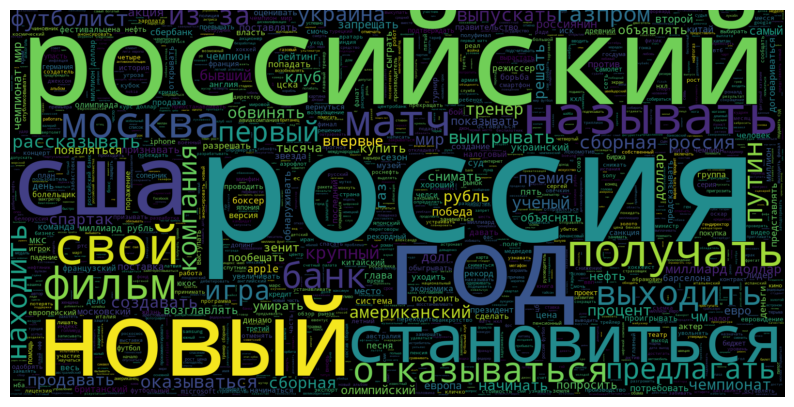

In [38]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(train_df[train_df.is_fake == 0].title))
plt.axis('off')
plt.imshow(wc,interpolation = 'bilinear')

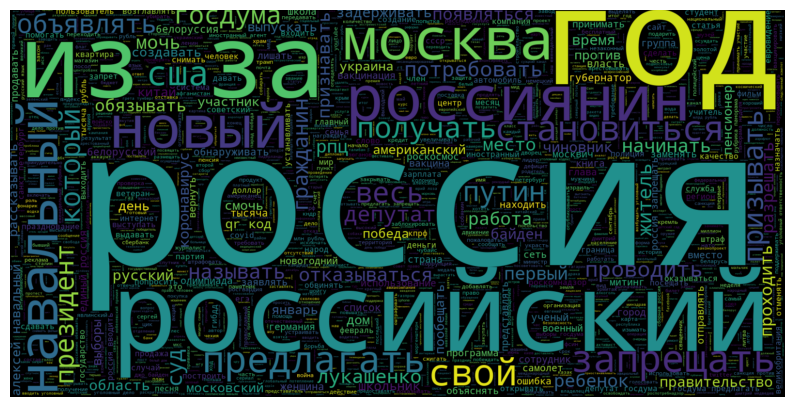

In [39]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(train_df[train_df.is_fake == 1].title))
plt.axis('off')
plt.imshow(wc,interpolation = 'bilinear')

In [40]:
x_train = train_df['title']
y_train = train_df['is_fake']

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [41]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocab size : ",vocab_size)


print(x_train)

Vocab size :  9621
3691    wada запрещать уроженец кавказ выступать росси...
4453    ea анонсировать дополнение  « дворец »  игра t...
52      сырьевой валюта оказываться устойчивый падение...
2115    сша выдавать молоко российский оппозиционер оп...
1143                дорогой джон пора перебираться россия
                              ...                        
134           москва пройти фестиваль психоделический рок
413     московский метро начинать штрафовать отсутстви...
2422    ск возбуждать дело исчезновение полуостров зем...
5630            резолюция пасе дело юкос россия волновать
2352           трент резнор записывать кавер led zeppelin
Name: title, Length: 4606, dtype: object


In [42]:
x_train = pad_sequences(
    tokenizer.texts_to_sequences(x_train),
    maxlen = 256)
x_val = pad_sequences(
    tokenizer.texts_to_sequences(x_val),
    maxlen = 256)
#x_test = pad_sequences(
#    tokenizer.texts_to_sequences(test_df['text']),
#    maxlen = 256)

print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_val shape: (1152, 256)
y_val shape: (1152,)


In [43]:
inputs = Input(shape=(256,), dtype='int32')

embedding = tf.keras.layers.Embedding(vocab_size, 300)(inputs)
net = SpatialDropout1D(0.2)(embedding)
net = Bidirectional(LSTM(128,dropout=0.2, recurrent_dropout=0.2))(net)
net = Dense(64,activation = 'relu')(net)
net = Dropout(0.3)(net)
net = Dense(1,activation = 'sigmoid')(net)

outputs = net
model = tf.keras.Model(inputs,outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding (Embedding)       (None, 256, 300)          2886300   
                                                                 
 spatial_dropout1d (SpatialD  (None, 256, 300)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0     

In [44]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

history = model.fit(
    x_train,
    y_train,
    batch_size=1024, 
    epochs=10,
    validation_data=(x_val, y_val)
)

Epoch 1/10
5/5 [==============================] - 66s 11s/step - loss: 0.6883 - accuracy: 0.5604 - val_loss: 0.6704 - val_accuracy: 0.6163
Epoch 2/10
5/5 [==============================] - 52s 10s/step - loss: 0.6481 - accuracy: 0.7002 - val_loss: 0.5986 - val_accuracy: 0.7465
Epoch 3/10
5/5 [==============================] - 52s 10s/step - loss: 0.5656 - accuracy: 0.7447 - val_loss: 0.5409 - val_accuracy: 0.7266
Epoch 4/10
5/5 [==============================] - 51s 10s/step - loss: 0.4643 - accuracy: 0.8044 - val_loss: 0.6046 - val_accuracy: 0.6953
Epoch 5/10
5/5 [==============================] - 51s 10s/step - loss: 0.3909 - accuracy: 0.8328 - val_loss: 0.4840 - val_accuracy: 0.7743
Epoch 6/10
5/5 [==============================] - 51s 10s/step - loss: 0.2733 - accuracy: 0.9032 - val_loss: 0.3530 - val_accuracy: 0.8368
Epoch 7/10
5/5 [==============================] - 51s 10s/step - loss: 0.1889 - accuracy: 0.9394 - val_loss: 0.3961 - val_accuracy: 0.8281
Epoch 8/10
5/5 [===========

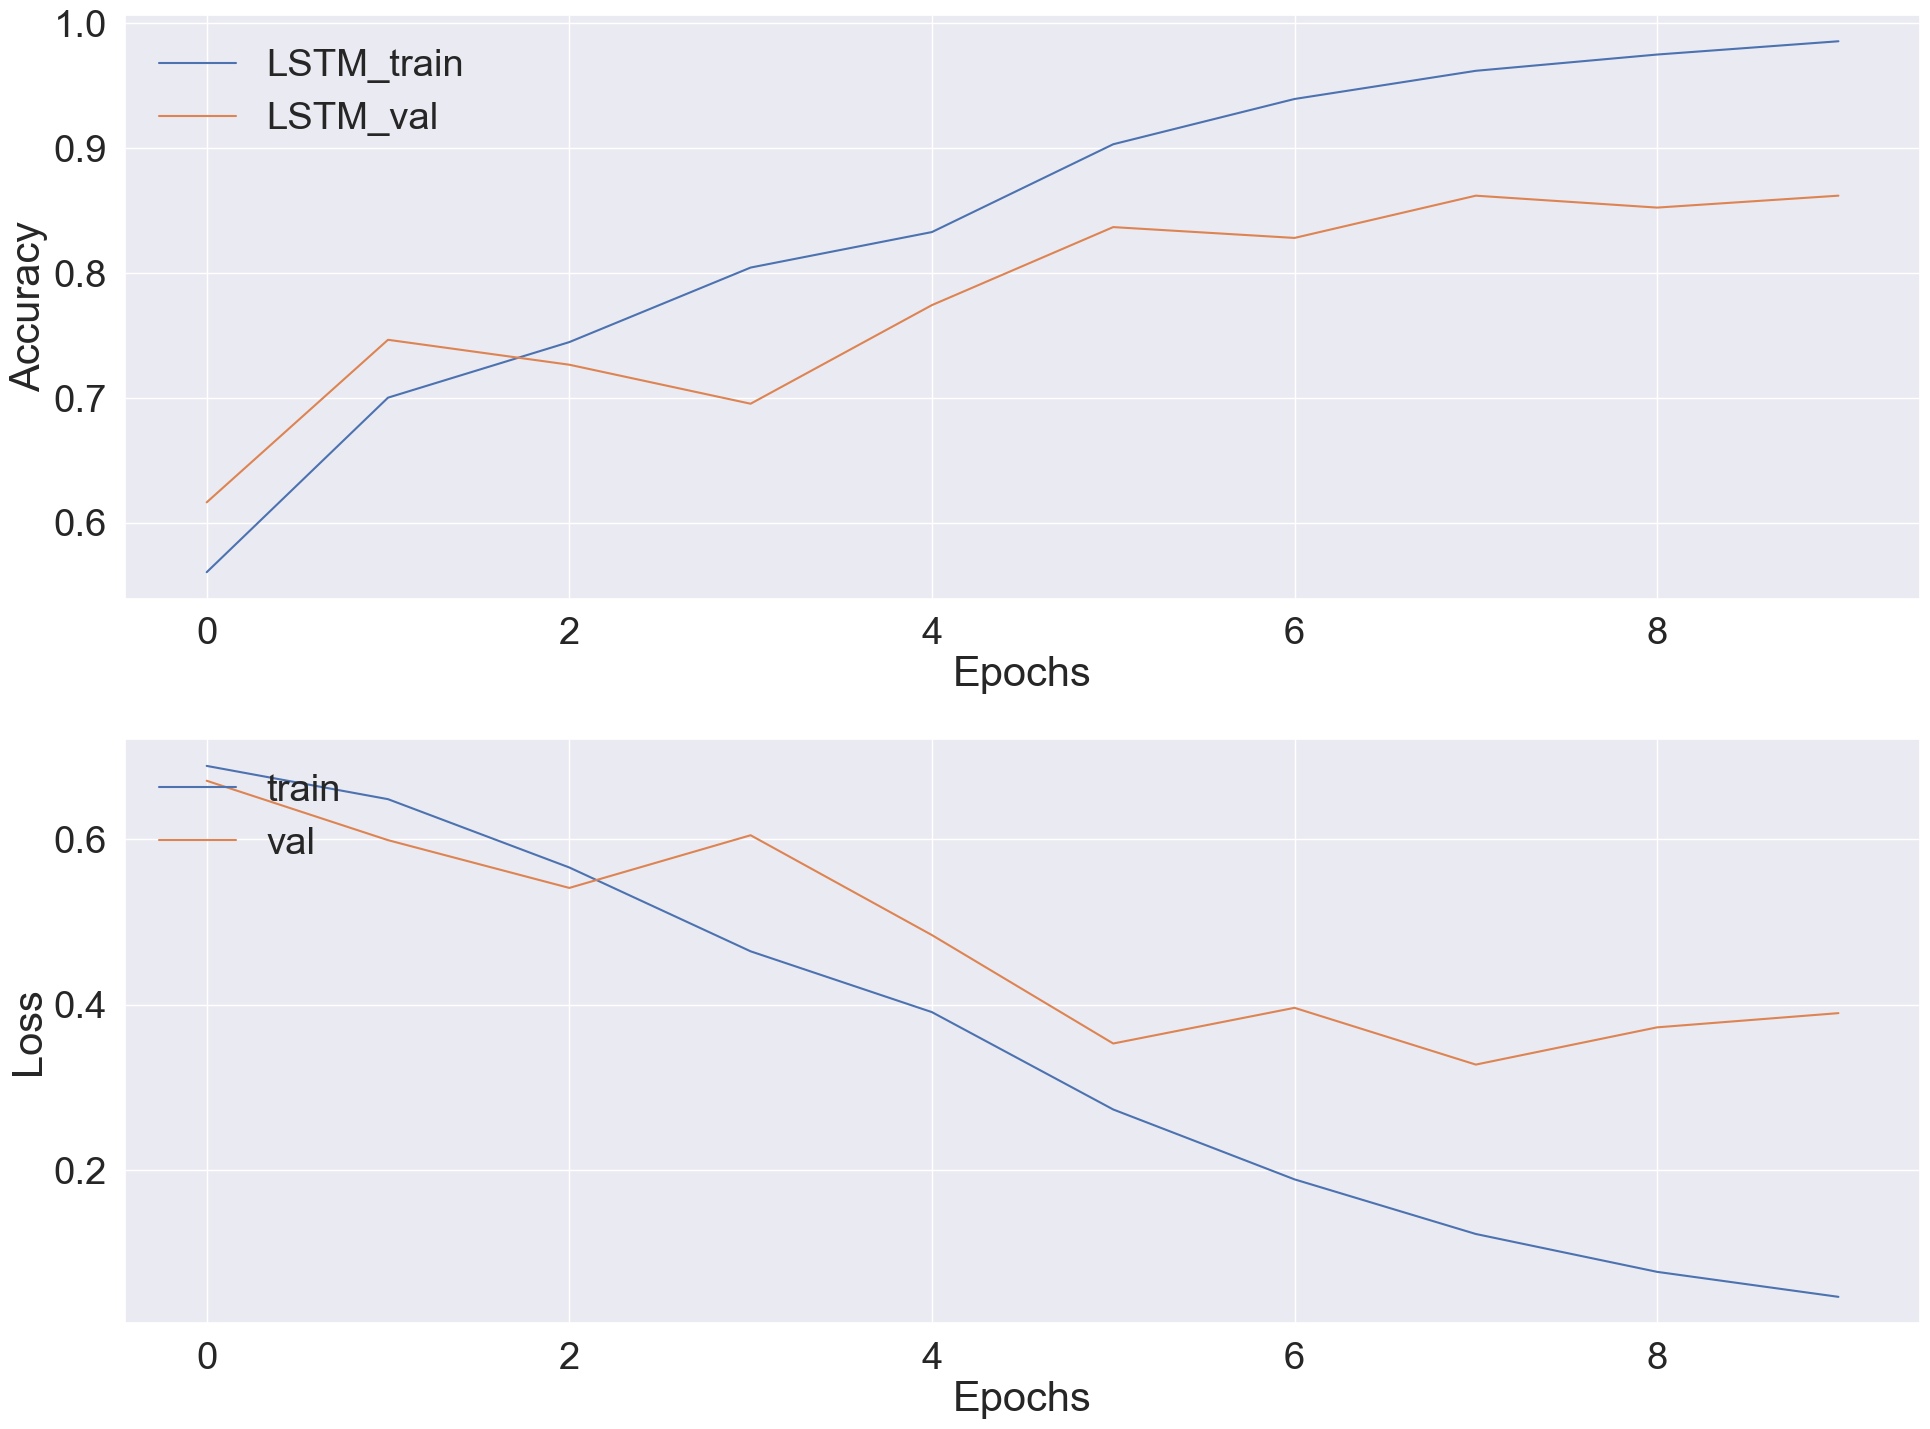

In [45]:
f,ax = plt.subplots(2,1,figsize=(20,15))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['LSTM_train', 'LSTM_val'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.show()

In [46]:
!pip install --quiet transformers
!pip install torchvision 
import torch
from transformers import TFBertModel, BertTokenizer


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: C:\Users\nikol\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: C:\Users\nikol\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [47]:
#get BERT layer
bert_layers = TFBertModel.from_pretrained('cointegrated/rubert-tiny2', from_pt=True)

#get BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("cointegrated/rubert-tiny2")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [48]:
encode = bert_tokenizer.encode("Привет рад встрече !")
decode = bert_tokenizer.decode(encode)

print("Encode: ", encode)
print("Decode: ", decode)

Encode:  [2, 51343, 16743, 31577, 5, 3]
Decode:  [CLS] Привет рад встрече! [SEP]


In [49]:
def bert_encode(data, max_len) :
    input_ids = [] 
    attention_masks = []
    
    for i in range(len(data)):
        encoded = bert_tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [50]:
x_train_bert = train_df['title']
y_train_bert = train_df['is_fake']

train_input_ids, train_attention_masks = bert_encode(x_train_bert,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\nikol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [55]:
input_ids = tf.keras.Input(shape=(60,),dtype='int32',name='input_ids')
attention_masks = tf.keras.Input(shape=(60,),dtype='int32',name='attention_masks')

output = bert_layers([input_ids,attention_masks])
output = output[1]
net = tf.keras.layers.Dense(32,activation='relu')(output)
net = tf.keras.layers.Dropout(0.2)(net)
net = tf.keras.layers.Dense(1,activation='sigmoid')(net)
outputs = net

model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = outputs)

In [56]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 60)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  29193768    ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                          

In [57]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train_bert,
    validation_split=0.2, 
    epochs=10,
    batch_size=256)

Epoch 1/10
18/18 [==============================] - 61s 3s/step - loss: 0.6018 - accuracy: 0.7423 - val_loss: 0.5121 - val_accuracy: 0.8715
Epoch 2/10
18/18 [==============================] - 56s 3s/step - loss: 0.4169 - accuracy: 0.9364 - val_loss: 0.3936 - val_accuracy: 0.8811
Epoch 3/10
18/18 [==============================] - 56s 3s/step - loss: 0.3064 - accuracy: 0.9425 - val_loss: 0.3355 - val_accuracy: 0.8785
Epoch 4/10
18/18 [==============================] - 56s 3s/step - loss: 0.2387 - accuracy: 0.9505 - val_loss: 0.3093 - val_accuracy: 0.8793
Epoch 5/10
18/18 [==============================] - 56s 3s/step - loss: 0.1961 - accuracy: 0.9535 - val_loss: 0.3035 - val_accuracy: 0.8785
Epoch 6/10
18/18 [==============================] - 56s 3s/step - loss: 0.1686 - accuracy: 0.9581 - val_loss: 0.3042 - val_accuracy: 0.8785
Epoch 7/10
18/18 [==============================] - 56s 3s/step - loss: 0.1484 - accuracy: 0.9577 - val_loss: 0.3107 - val_accuracy: 0.8759
Epoch 8/10
18/18 [==

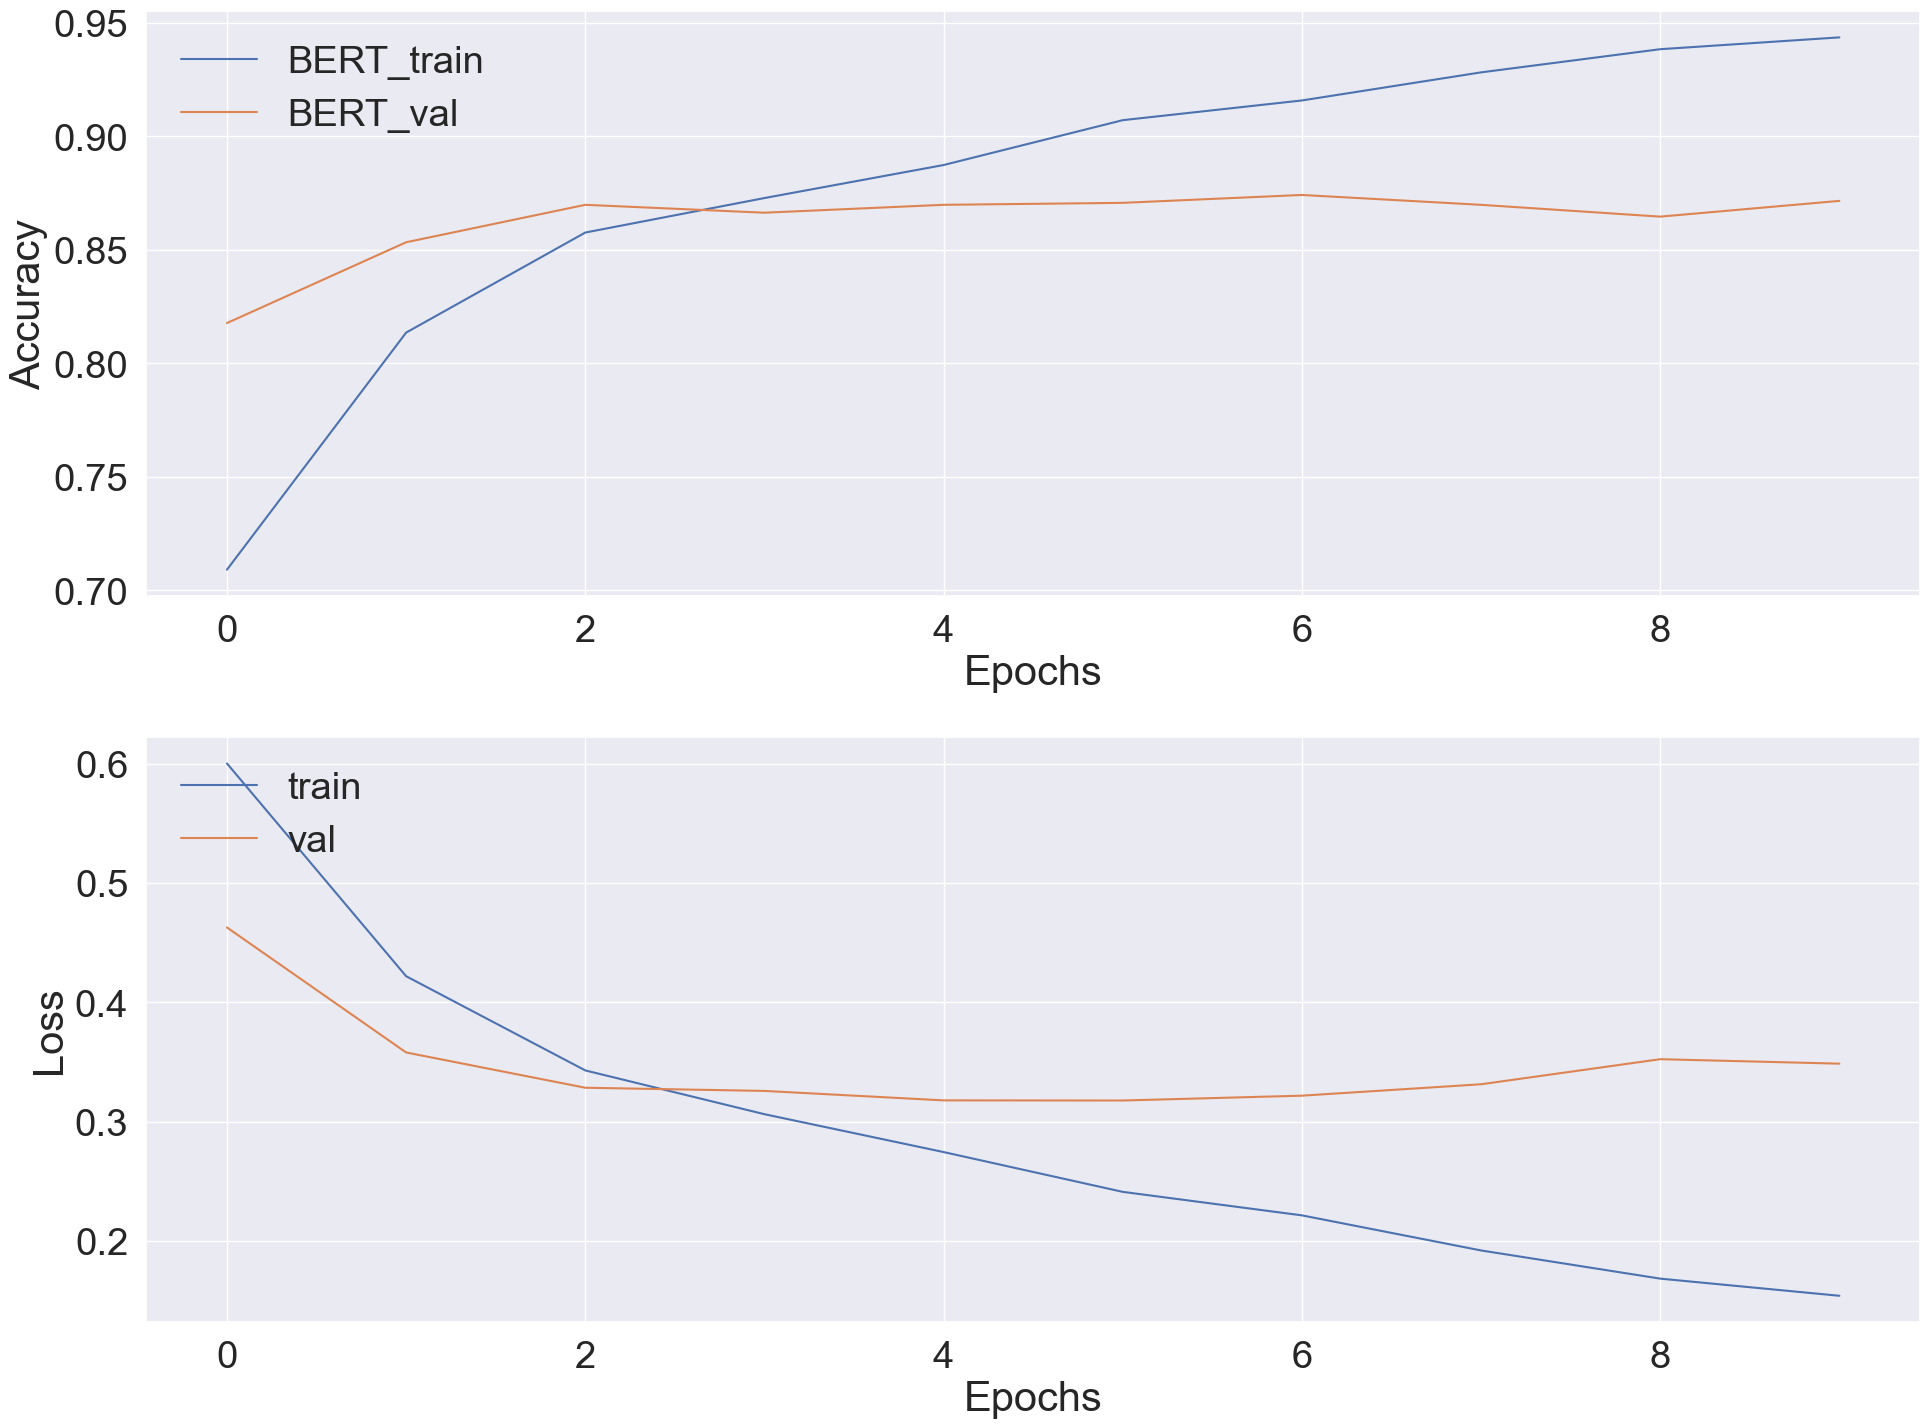

In [54]:
f,ax = plt.subplots(2,1,figsize=(20,15))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['BERT_train', 'BERT_val'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.show()